Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

Device Configuration

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


Data Prep

In [3]:
# Download and load the CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Set Random Seed

In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

Validation

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

Calculate Test Error

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

Train Model

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

Metrics Calculation

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

Model Architecture

In [9]:
# ResNet-18 with no pre-trained weights
def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adjusting for 10 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

Loss Function

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

Optimizer

In [11]:
def initialize_optimizer(model_params):
    return optim.Adam(model_params, lr=0.001)

Run

Run: 1
Seed: 9355
Epoch 1/200, Train Loss: 3.7408807814121245, Validation Loss: 3.3248579263687135, Test Error: 80.98
Epoch 2/200, Train Loss: 3.9340227127075194, Validation Loss: 3.6331676959991457, Test Error: 85.12
Epoch 3/200, Train Loss: 3.344260311126709, Validation Loss: 3.3494024991989138, Test Error: 79.71000000000001
Epoch 4/200, Train Loss: 3.065031683444977, Validation Loss: 3.235890531539917, Test Error: 77.9
Epoch 5/200, Train Loss: 2.8593960404396057, Validation Loss: 3.1547903776168824, Test Error: 75.64
Epoch 6/200, Train Loss: 2.647178554534912, Validation Loss: 3.1715330362319945, Test Error: 75.52
Epoch 7/200, Train Loss: 2.4922443449497225, Validation Loss: 3.69331374168396, Test Error: 77.62
Epoch 8/200, Train Loss: 2.6152131974697115, Validation Loss: 2.956635928153992, Test Error: 70.85
Epoch 9/200, Train Loss: 2.203012043237686, Validation Loss: 2.8920111894607543, Test Error: 68.53
Epoch 10/200, Train Loss: 1.9823993772268296, Validation Loss: 3.01075391769409

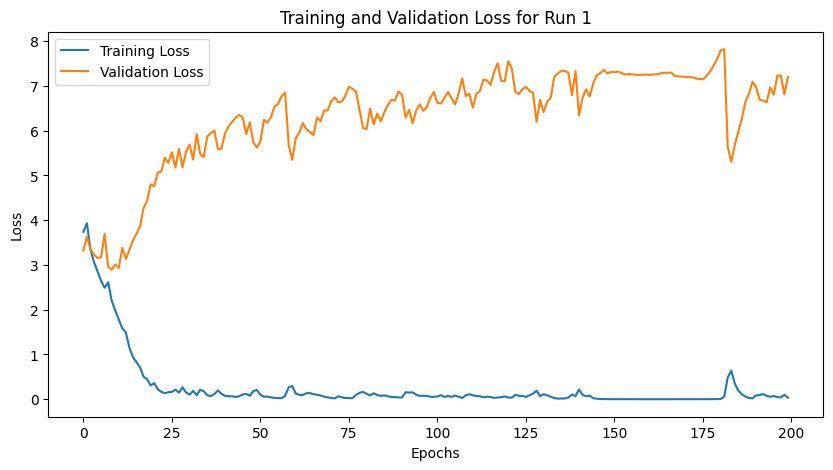

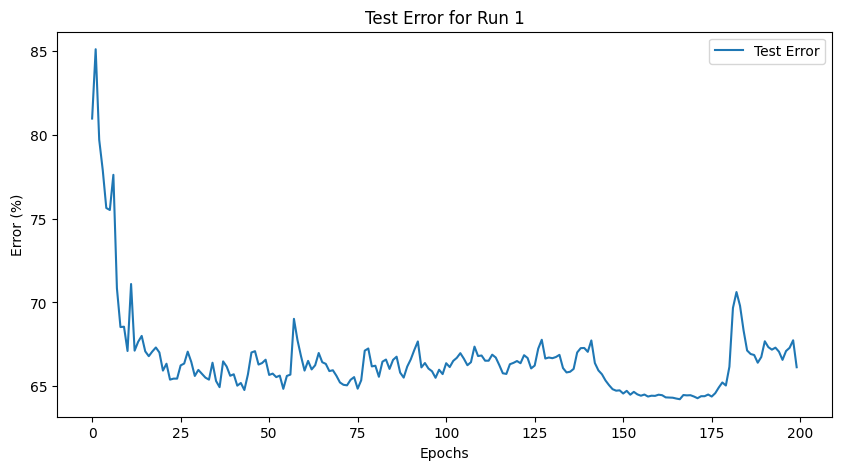

Run: 2
Seed: 4955
Epoch 1/200, Train Loss: 3.725094735622406, Validation Loss: 3.374827766418457, Test Error: 81.59
Epoch 2/200, Train Loss: 3.8208485782146453, Validation Loss: 3.459792733192444, Test Error: 82.3
Epoch 3/200, Train Loss: 3.2338147342205046, Validation Loss: 3.482368278503418, Test Error: 82.18
Epoch 4/200, Train Loss: 3.0181811928749083, Validation Loss: 3.1928062200546266, Test Error: 77.58
Epoch 5/200, Train Loss: 2.8102689683437347, Validation Loss: 3.101058530807495, Test Error: 74.99
Epoch 6/200, Train Loss: 2.614192098379135, Validation Loss: 3.1683305978775023, Test Error: 74.9
Epoch 7/200, Train Loss: 2.4636141777038576, Validation Loss: 2.9530665636062623, Test Error: 71.03999999999999
Epoch 8/200, Train Loss: 2.240194636583328, Validation Loss: 2.992593860626221, Test Error: 71.26
Epoch 9/200, Train Loss: 2.062191736698151, Validation Loss: 2.8701647996902464, Test Error: 68.25
Epoch 10/200, Train Loss: 1.8452681213617326, Validation Loss: 2.890072464942932,

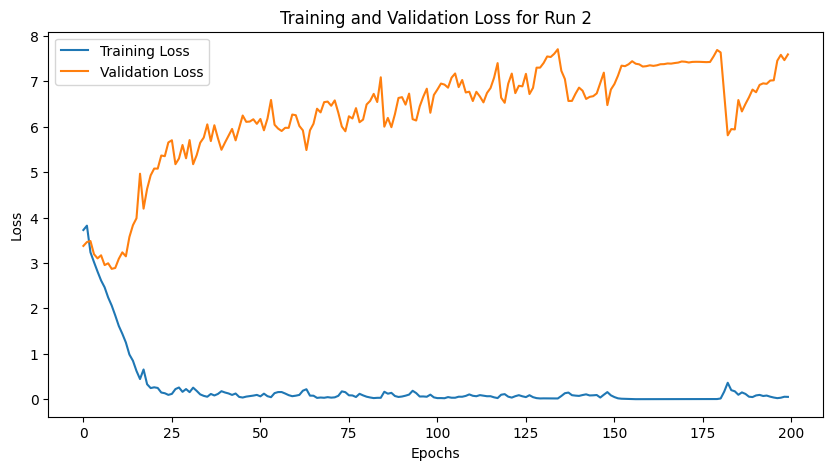

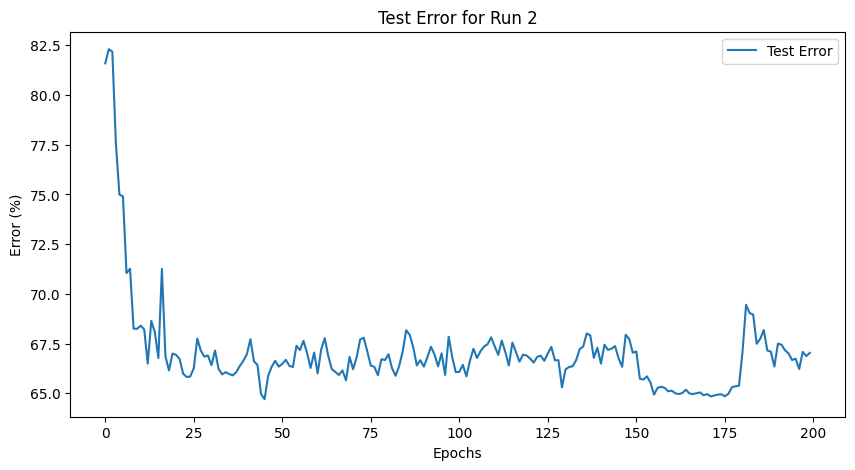

Run: 3
Seed: 1081
Epoch 1/200, Train Loss: 3.707261103391647, Validation Loss: 3.3706711769104003, Test Error: 83.3
Epoch 2/200, Train Loss: 4.062266612052918, Validation Loss: 3.702367877960205, Test Error: 87.34
Epoch 3/200, Train Loss: 3.4232019007205965, Validation Loss: 3.5666977882385256, Test Error: 82.37
Epoch 4/200, Train Loss: 3.1784105479717253, Validation Loss: 3.2466208696365357, Test Error: 78.08
Epoch 5/200, Train Loss: 2.9206152737140654, Validation Loss: 3.158187437057495, Test Error: 75.78
Epoch 6/200, Train Loss: 2.768928611278534, Validation Loss: 3.044529914855957, Test Error: 73.96000000000001
Epoch 7/200, Train Loss: 2.547437089681625, Validation Loss: 3.0275556802749635, Test Error: 73.05
Epoch 8/200, Train Loss: 2.369207412004471, Validation Loss: 2.9855458736419678, Test Error: 71.7
Epoch 9/200, Train Loss: 2.2118789196014403, Validation Loss: 3.1645379304885863, Test Error: 71.62
Epoch 10/200, Train Loss: 2.0527219474315643, Validation Loss: 3.028829216957092

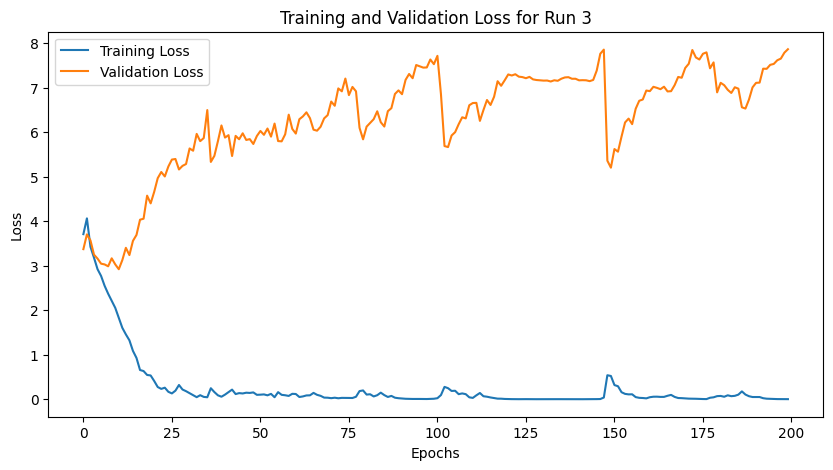

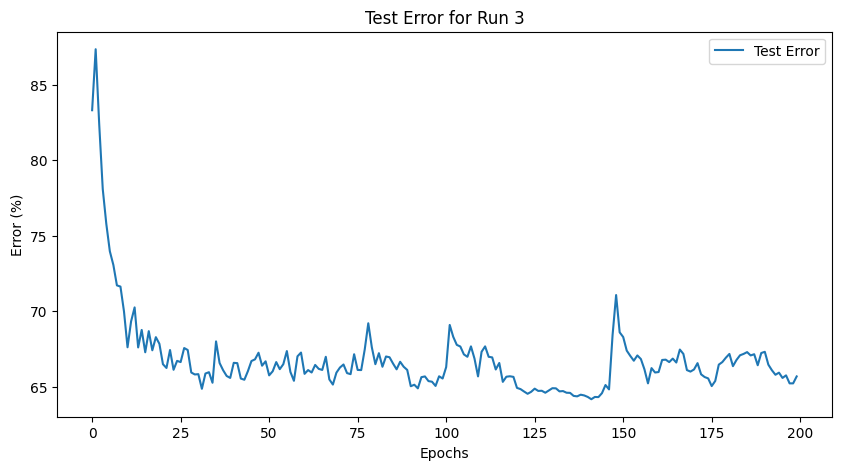

Run: 4
Seed: 7584
Epoch 1/200, Train Loss: 3.704077047109604, Validation Loss: 3.2865670680999757, Test Error: 82.97
Epoch 2/200, Train Loss: 4.010272914171219, Validation Loss: 3.7816901206970215, Test Error: 87.3
Epoch 3/200, Train Loss: 3.37858584523201, Validation Loss: 3.3368634462356566, Test Error: 79.46000000000001
Epoch 4/200, Train Loss: 3.065431773662567, Validation Loss: 3.0994428634643554, Test Error: 74.78
Epoch 5/200, Train Loss: 2.8622541308403013, Validation Loss: 2.9925258636474608, Test Error: 73.23
Epoch 6/200, Train Loss: 2.655508655309677, Validation Loss: 2.9659722566604616, Test Error: 72.61
Epoch 7/200, Train Loss: 2.490433895587921, Validation Loss: 2.909048390388489, Test Error: 70.66
Epoch 8/200, Train Loss: 2.2670687437057495, Validation Loss: 3.02828996181488, Test Error: 71.19
Epoch 9/200, Train Loss: 2.1364024937152863, Validation Loss: 2.900313663482666, Test Error: 69.33
Epoch 10/200, Train Loss: 1.9664776653051377, Validation Loss: 2.789131498336792, 

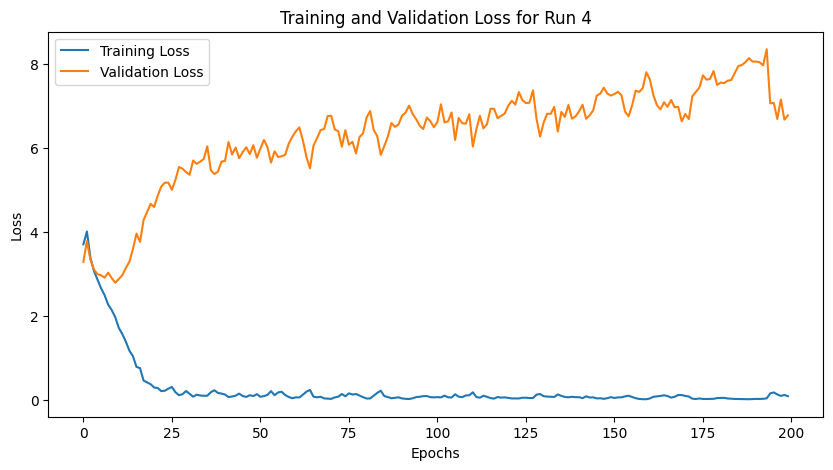

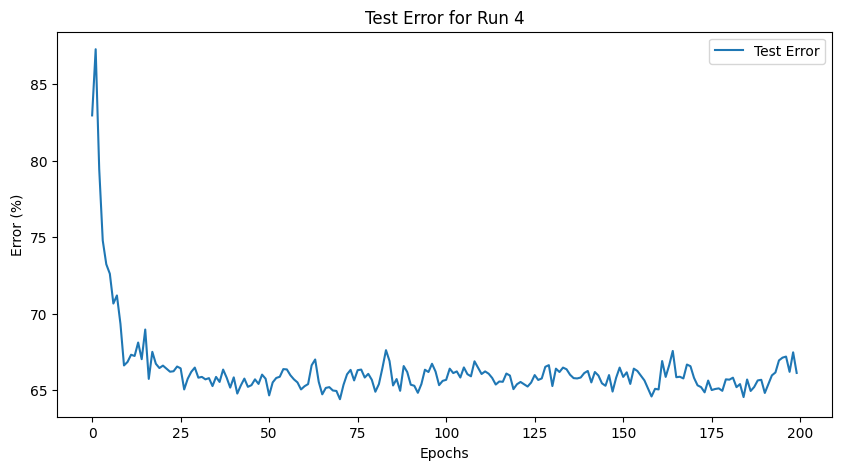

Run: 5
Seed: 6441
Epoch 1/200, Train Loss: 3.7037681341171265, Validation Loss: 3.3727567911148073, Test Error: 82.78
Epoch 2/200, Train Loss: 4.125326943397522, Validation Loss: 3.749120759963989, Test Error: 87.78999999999999
Epoch 3/200, Train Loss: 3.466626113653183, Validation Loss: 3.613771843910217, Test Error: 85.39
Epoch 4/200, Train Loss: 3.1713040113449096, Validation Loss: 3.3826079845428465, Test Error: 79.88
Epoch 5/200, Train Loss: 2.9635880410671236, Validation Loss: 3.325257658958435, Test Error: 78.42
Epoch 6/200, Train Loss: 2.7852580845355988, Validation Loss: 3.352931332588196, Test Error: 77.75
Epoch 7/200, Train Loss: 2.6240622758865357, Validation Loss: 2.9552632570266724, Test Error: 71.99
Epoch 8/200, Train Loss: 2.416147509217262, Validation Loss: 2.9581230878829956, Test Error: 71.28
Epoch 9/200, Train Loss: 2.254754680395126, Validation Loss: 3.032219123840332, Test Error: 71.56
Epoch 10/200, Train Loss: 2.1209086388349534, Validation Loss: 2.81238932609558

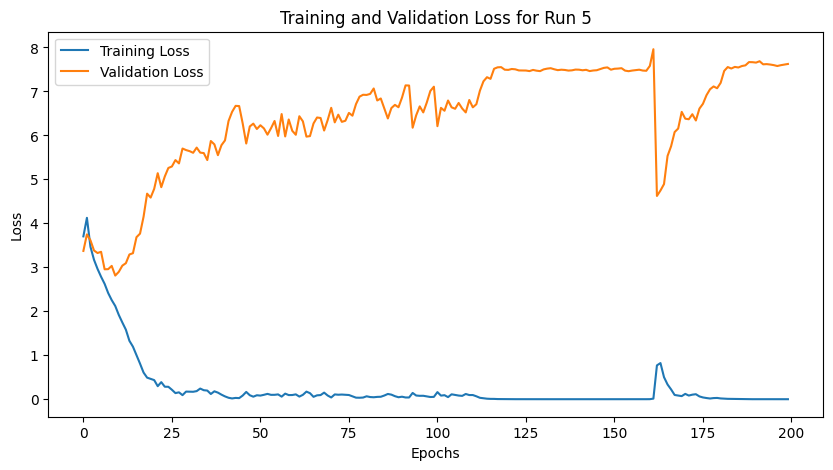

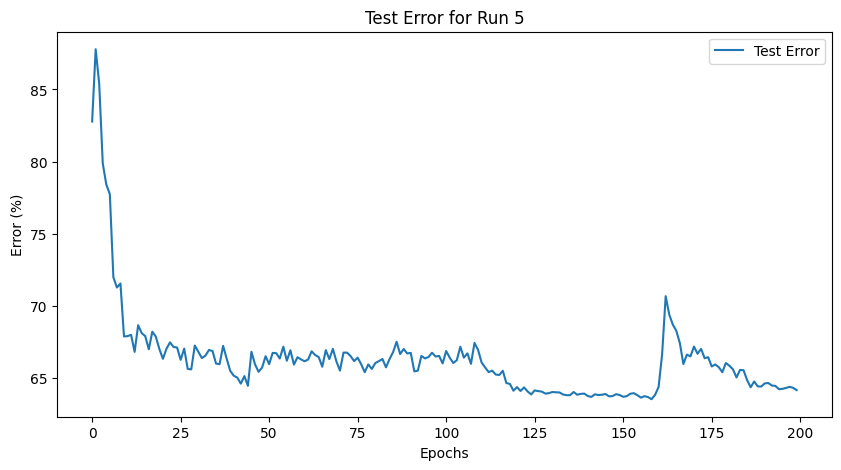

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Metrics Calculation and Plotting Mean Test Error

Mean Metrics: {'val_accuracy': 33.468, 'val_f1': 0.33267948024073146, 'val_recall': 0.33468, 'test_accuracy': 34.176, 'test_f1': 0.3401385571698909, 'test_recall': 0.34176}
Standard Deviation of Metrics: {'val_accuracy': 0.7307092445015324, 'val_f1': 0.0068657669294917055, 'val_recall': 0.007307092445015315, 'test_accuracy': 0.9375627978967592, 'test_f1': 0.009080879937055851, 'test_recall': 0.0093756279789676}


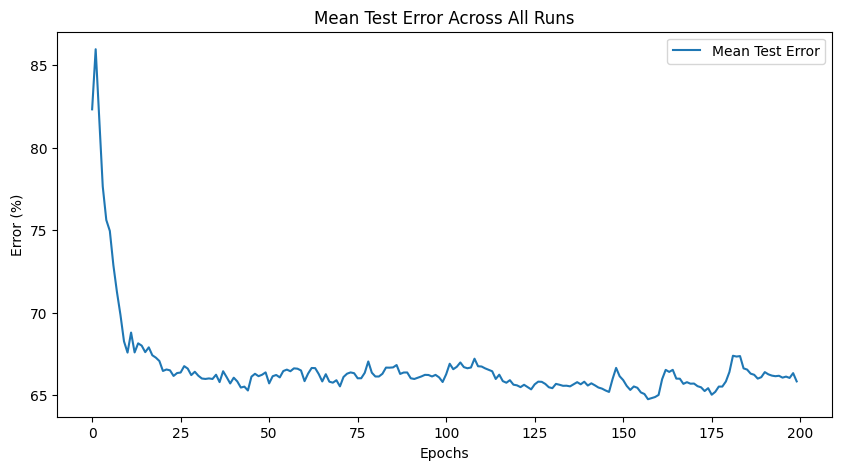

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

Save data

In [14]:
# Directory for saving results
save_dir = 'CIFAR_100_ResNet18_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'ADAM.json'), 'w') as f:
    json.dump(results, f)